In [1]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import aim
import PIL

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.train import train
from src.data.datasets import ACDCDataset
from src.training.metrics import dice_score, DiceLoss, evaluate

In [3]:
dataset = ACDCDataset(path='../../training/', tagged=True, verbose=1)

Loaded saved dataset of 952 images from /workspace/dev/tagroi/checkpoints/acdc_dataset_tagged.pt


In [4]:
train_set, val_set = random_split(dataset, [704, 248], generator=torch.Generator().manual_seed(42))
loader_train = DataLoader(train_set, batch_size=32, shuffle=True)
loader_val = DataLoader(val_set, batch_size=8, shuffle=False)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=1, n_classes=4, bilinear=True).double()
# Load old saved version of the model
saved_model = torch.load('../checkpoints/model/model_cine_tag_v1_sd.pt')
# Extract UNet if saved model is parallelized
# if isinstance(saved_model, nn.DataParallel):
    # saved_model = saved_model.module
model.load_state_dict(saved_model)

# if device.type == 'cuda':
    # model = nn.DataParallel(model)
    # model.n_classes = model.module.n_classes

<All keys matched successfully>

In [ ]:
saved_model.keys())

In [24]:
model = model.to(device)

In [25]:
images, targets = next(iter(loader_val))
images, targets = images.double().to(device), targets.long().to(device)
# predict the mask
outputs = model(images)

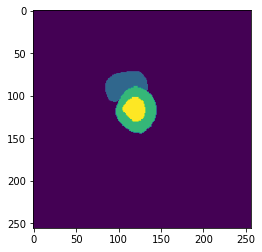

In [30]:
plt.imshow(targets.detach().cpu().numpy()[5])

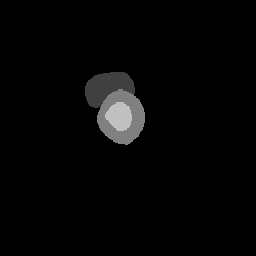

In [39]:
PIL.Image.fromarray(targets.detach().cpu().numpy()[5].astype('uint8') * round(256 / 4))

In [40]:
aim.Image(targets.detach().cpu().numpy()[5].astype('uint8') * round(256 / 4))

In [15]:
targets.detach().cpu().numpy()[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
evaluate(model, loader_train, device)

tensor([9.7994e-01, 9.4171e-04, 1.6551e-03, 2.1295e-04], device='cuda:0')

In [9]:
images, targets = next(iter(loader_train))
images, targets = images.double().to(device), targets.long().to(device)

In [10]:
# model.eval()
outputs = model(images)

In [11]:
prediction = F.softmax(outputs, dim=1).argmax(dim=1)

In [12]:
# without model.eval()
dice_score(outputs, targets)

tensor([0.9886, 0.2665, 0.2946, 0.4166], device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [25]:
# with model.eval()
dice_score(outputs, targets)

tensor([9.8296e-01, 9.3969e-04, 1.5676e-03, 1.9940e-04], device='cuda:0',
       dtype=torch.float64, grad_fn=<MeanBackward1>)

In [81]:
# no grad
dice_score(outputs, targets)

tensor([0.9896, 0.3588, 0.4603, 0.5062], device='cuda:0', dtype=torch.float64)

IndexError: index 16 is out of bounds for axis 0 with size 16

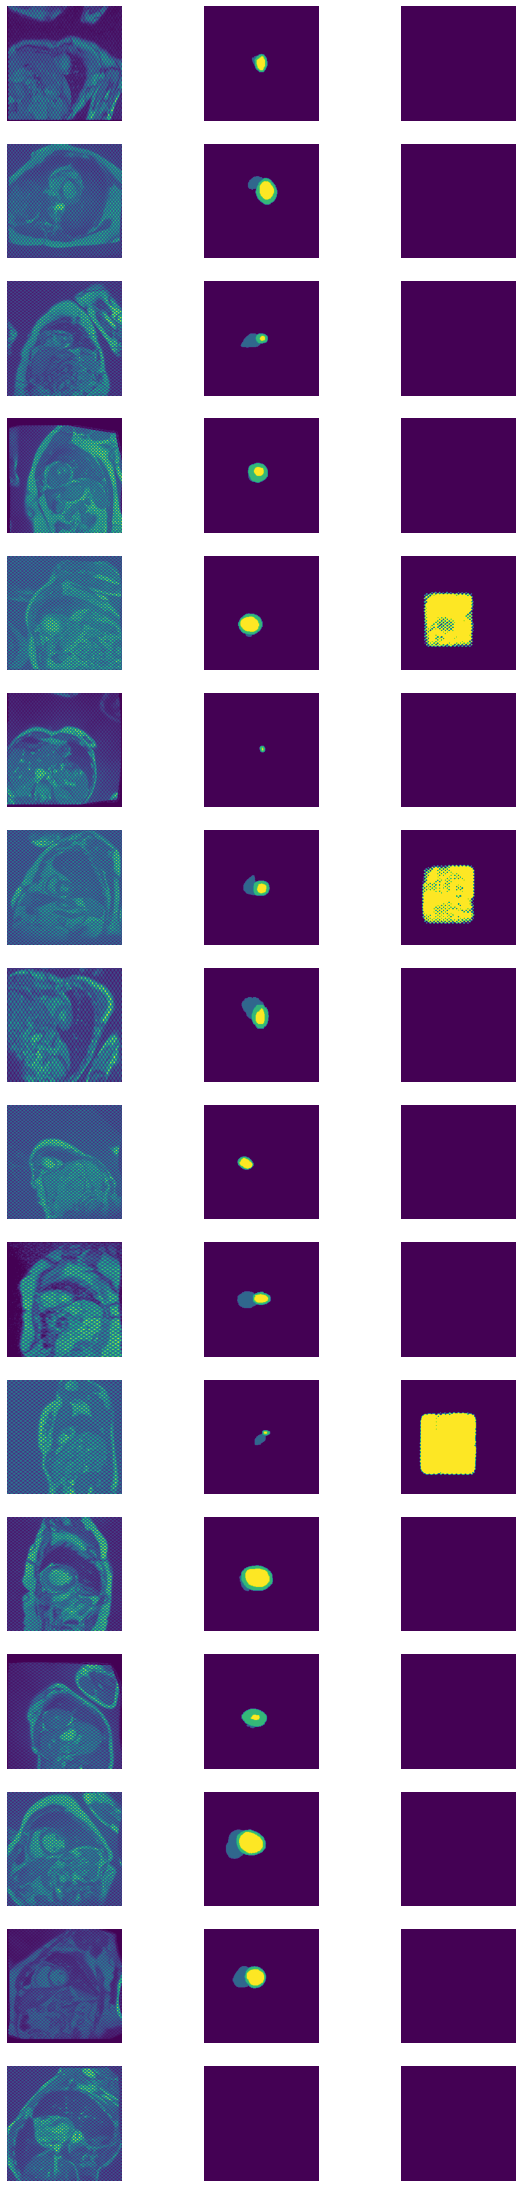

In [26]:
fig, ax = plt.subplots(16, 3, figsize=(10, 40))

for i in range(images.shape[0]):

    ax[i, 0].imshow(images[i, 0].detach().cpu().numpy()), ax[i, 0].axis('off')
    ax[i, 1].imshow(targets[i].detach().cpu().numpy()), ax[i, 1].axis('off')
    ax[i, 2].imshow(prediction[i].detach().cpu().numpy()), ax[i, 2].axis('off')


In [41]:
evaluate(model, loader_train, device)

tensor([9.7995e-01, 9.2533e-04, 1.6302e-03, 2.0828e-04], device='cuda:0')

In [11]:
criterion = nn.CrossEntropyLoss()
dice_criterion = DiceLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)

In [19]:
for epoch in range(4):
    
    dice = torch.zeros(4)
    acc_loss = 0.

    model.train()

    batch_pbar = tqdm(loader_train, total=len(loader_train), unit='batch', leave=False)
    for inputs, targets in loader_train:

        batch_pbar.set_description(f'Acummulated loss: {acc_loss:.4f}')
        # move to device
        # target is index of classes
        inputs, targets = inputs.double().to(device), targets.long().to(device)
        
        with torch.cuda.amp.autocast(enabled=amp):
            outputs = model(inputs)
            loss = criterion(outputs, targets) + \
                dice_criterion(outputs, targets, exclude_bg=True)

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

        dice += dice_score(outputs, targets)
        acc_loss += loss.item()

    # Tracking training performance
    train_perf = dice / len(loader_train)
    avg_dice = train_perf.mean()

    status = f'Epoch {epoch:03} \t Loss {acc_loss:.4f} \t Dice {avg_dice:.4f}'
    
    # Tracking validation performance
    val_perf = evaluate(model, loader_val, device)
    avg_val_dice = val_perf.mean()
    scheduler.step(avg_val_dice)

    status += f'\t Val. Dice {avg_val_dice:.4f}'

    print(status)

  0%|          | 0/2 [00:00<?, ?batch/s]

RuntimeError: NCCL Error 2: unhandled system error

In [27]:
image, mask = next(iter(loader_train))
output = model(image.double().to(device))

In [28]:
nn.CrossEntropyLoss()(output, mask.long().to(device))

tensor(1.3304, device='cuda:0', dtype=torch.float64,
       grad_fn=<NllLoss2DBackward0>)

In [29]:
DiceLoss(exclude_bg=True)(output, mask.long().to(device))

tensor(0.7245, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

In [30]:
dice_score(output, mask.long().to(device))

tensor([0.2520, 0.2978, 0.2585, 0.2920, 0.2425, 0.2999, 0.2377, 0.3003],
       device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [33]:
input_soft = F.softmax(output, dim=1)

In [38]:
from kornia.utils.one_hot import one_hot

target_one_hot = one_hot(mask.long().to(device), 4, device, output.dtype)

In [63]:
dims = (2, 3)
intersection = torch.sum(input_soft * target_one_hot, dims)
cardinality = torch.sum(input_soft + target_one_hot, dims)

dice_score = 2.0 * intersection / (cardinality + 1e-8)

In [73]:
per_class = dice_score.mean(dim=0)
per_class

tensor([0.4253, 0.0287, 0.0270, 0.0301], device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [76]:
torch.mean(-per_class[1:] + 1.)

tensor(0.9714, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)